In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [7]:
path = os.getcwd() + '\\augmented_data\\'
trainX = np.zeros((72_800, 256, 256))

In [8]:
update_per = 10000
curve = lambda x: np.sqrt(x)

for n, i in enumerate(os.listdir(path)):
    filename = os.fsdecode(i)
    temp_img = cv2.imread(path + filename, 0)
    temp_img = cv2.resize(temp_img, (256, 256))
    trainX[n] = curve(np.asarray(temp_img))
    if n % update_per == 0:
        print(f'Image #: {n}')

Image #: 0
Image #: 10000
Image #: 20000
Image #: 30000
Image #: 40000
Image #: 50000
Image #: 60000
Image #: 70000


In [4]:
trainY = np.zeros(len(trainX))

In [15]:
# generator network
# maybe try different activation?

random_input = tf.keras.layers.Input(shape = 50)

x = tf.keras.layers.Dense(1200, activation='relu')(random_input)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tf.keras.layers.Dense(256 * 256)(x)
x = tf.keras.layers.Reshape((256, 256, 1))(x)

generated_image = tf.keras.layers.Activation('sigmoid')(x)

generator_network = tf.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_9 (Dense)             (None, 1200)              61200     
                                                                 
 batch_normalization_4 (Batc  (None, 1200)             4800      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 1000)              1201000   
                                                                 
 batch_normalization_5 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 65536)             6560

In [16]:
# discriminator network

image_input = tf.keras.layers.Input(shape=(256, 256, 1))

x = tf.keras.layers.Flatten()(image_input)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1)(x)

real_vs_fake_output = tf.keras.layers.Activation('sigmoid')(x)

discriminator_network = tf.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               16777472  
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 129 

In [17]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [18]:
# combined model

discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

gan_model = tf.keras.models.Model(random_input, d_output)
gan_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 model_4 (Functional)        (None, 256, 256, 1)       66872536  
                                                                 
 model_5 (Functional)        (None, 1)                 16810497  
                                                                 
Total params: 83,683,033
Trainable params: 66,868,136
Non-trainable params: 16,814,897
_________________________________________________________________


In [19]:
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

In [14]:
# generator_network = tf.keras.models.load_model(os.getcwd() + '\\generator')
# maybe resetting disc will increase performance?
# discriminator_network = tf.keras.models.load_model(os.getcwd() + '\\discriminator')

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

gan_model = tf.keras.models.Model(random_input, d_output)

gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

In [20]:
# data generators

indices = [i for i in range(len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

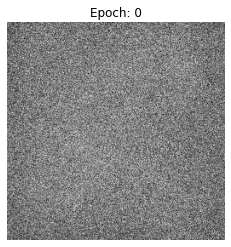

Epoch: 0, Step: 0, D-Loss: 4.237, D-Acc: 62.000, G-Loss: 1.194
Epoch: 0, Step: 50, D-Loss: 0.953, D-Acc: 56.000, G-Loss: 0.798
Epoch: 0, Step: 100, D-Loss: 1.785, D-Acc: 55.000, G-Loss: 0.817
Epoch: 0, Step: 150, D-Loss: 3.233, D-Acc: 54.000, G-Loss: 0.819
Epoch: 0, Step: 200, D-Loss: 0.671, D-Acc: 58.000, G-Loss: 0.807
Epoch: 0, Step: 250, D-Loss: 0.628, D-Acc: 59.000, G-Loss: 0.785
Epoch: 0, Step: 300, D-Loss: 0.666, D-Acc: 54.000, G-Loss: 0.769
Epoch: 0, Step: 350, D-Loss: 0.685, D-Acc: 53.000, G-Loss: 0.730
Epoch: 0, Step: 400, D-Loss: 0.710, D-Acc: 52.000, G-Loss: 0.751
Epoch: 0, Step: 450, D-Loss: 0.688, D-Acc: 51.000, G-Loss: 0.744
Epoch: 1, Step: 0, D-Loss: 0.636, D-Acc: 59.000, G-Loss: 0.742
Epoch: 1, Step: 50, D-Loss: 0.643, D-Acc: 57.000, G-Loss: 0.757
Epoch: 1, Step: 100, D-Loss: 0.679, D-Acc: 53.000, G-Loss: 0.761
Epoch: 1, Step: 150, D-Loss: 0.685, D-Acc: 52.000, G-Loss: 0.760
Epoch: 1, Step: 200, D-Loss: 0.639, D-Acc: 58.000, G-Loss: 0.761
Epoch: 1, Step: 250, D-Loss: 0.

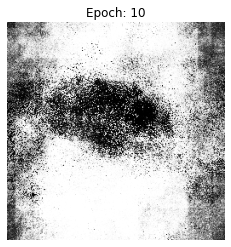

Epoch: 10, Step: 0, D-Loss: 0.669, D-Acc: 53.000, G-Loss: 0.726
Epoch: 10, Step: 50, D-Loss: 0.665, D-Acc: 54.000, G-Loss: 0.730
Epoch: 10, Step: 100, D-Loss: 0.694, D-Acc: 53.000, G-Loss: 0.718
Epoch: 10, Step: 150, D-Loss: 0.683, D-Acc: 52.000, G-Loss: 0.724
Epoch: 10, Step: 200, D-Loss: 0.694, D-Acc: 50.000, G-Loss: 0.720
Epoch: 10, Step: 250, D-Loss: 0.665, D-Acc: 54.000, G-Loss: 0.719
Epoch: 10, Step: 300, D-Loss: 0.698, D-Acc: 53.000, G-Loss: 0.721
Epoch: 10, Step: 350, D-Loss: 0.665, D-Acc: 54.000, G-Loss: 0.714
Epoch: 10, Step: 400, D-Loss: 0.679, D-Acc: 52.000, G-Loss: 0.719
Epoch: 10, Step: 450, D-Loss: 0.689, D-Acc: 51.000, G-Loss: 0.716
Epoch: 11, Step: 0, D-Loss: 0.680, D-Acc: 52.000, G-Loss: 0.714
Epoch: 11, Step: 50, D-Loss: 0.672, D-Acc: 53.000, G-Loss: 0.718
Epoch: 11, Step: 100, D-Loss: 0.665, D-Acc: 54.000, G-Loss: 0.720
Epoch: 11, Step: 150, D-Loss: 0.665, D-Acc: 54.000, G-Loss: 0.723
Epoch: 11, Step: 200, D-Loss: 0.650, D-Acc: 56.000, G-Loss: 0.734
Epoch: 11, Step:

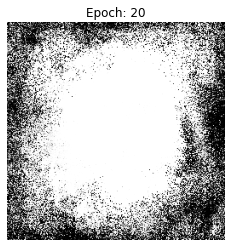

Epoch: 20, Step: 0, D-Loss: 0.491, D-Acc: 80.000, G-Loss: 1.162
Epoch: 20, Step: 50, D-Loss: 0.437, D-Acc: 81.000, G-Loss: 1.124
Epoch: 20, Step: 100, D-Loss: 0.367, D-Acc: 86.000, G-Loss: 1.160
Epoch: 20, Step: 150, D-Loss: 0.377, D-Acc: 85.000, G-Loss: 1.145
Epoch: 20, Step: 200, D-Loss: 0.338, D-Acc: 88.000, G-Loss: 1.184
Epoch: 20, Step: 250, D-Loss: 0.363, D-Acc: 89.000, G-Loss: 1.097
Epoch: 20, Step: 300, D-Loss: 0.366, D-Acc: 87.000, G-Loss: 1.121
Epoch: 20, Step: 350, D-Loss: 0.329, D-Acc: 88.000, G-Loss: 1.243
Epoch: 20, Step: 400, D-Loss: 0.337, D-Acc: 91.000, G-Loss: 1.202
Epoch: 20, Step: 450, D-Loss: 0.359, D-Acc: 87.000, G-Loss: 1.156
Epoch: 21, Step: 0, D-Loss: 0.311, D-Acc: 89.000, G-Loss: 1.305
Epoch: 21, Step: 50, D-Loss: 0.268, D-Acc: 93.000, G-Loss: 1.320
Epoch: 21, Step: 100, D-Loss: 0.247, D-Acc: 97.000, G-Loss: 1.267
Epoch: 21, Step: 150, D-Loss: 0.295, D-Acc: 92.000, G-Loss: 1.300
Epoch: 21, Step: 200, D-Loss: 0.338, D-Acc: 89.000, G-Loss: 1.252
Epoch: 21, Step:

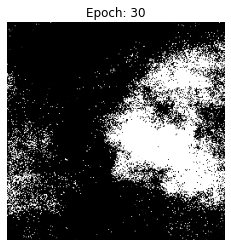

Epoch: 30, Step: 0, D-Loss: 0.159, D-Acc: 94.000, G-Loss: 2.057
Epoch: 30, Step: 50, D-Loss: 0.174, D-Acc: 95.000, G-Loss: 1.991
Epoch: 30, Step: 100, D-Loss: 0.182, D-Acc: 93.000, G-Loss: 2.249
Epoch: 30, Step: 150, D-Loss: 0.210, D-Acc: 93.000, G-Loss: 2.060
Epoch: 30, Step: 200, D-Loss: 0.178, D-Acc: 93.000, G-Loss: 2.238
Epoch: 30, Step: 250, D-Loss: 0.277, D-Acc: 92.000, G-Loss: 1.469
Epoch: 30, Step: 300, D-Loss: 0.179, D-Acc: 96.000, G-Loss: 1.867
Epoch: 30, Step: 350, D-Loss: 0.204, D-Acc: 94.000, G-Loss: 1.897
Epoch: 30, Step: 400, D-Loss: 0.145, D-Acc: 97.000, G-Loss: 1.867
Epoch: 30, Step: 450, D-Loss: 0.231, D-Acc: 93.000, G-Loss: 2.168
Epoch: 31, Step: 0, D-Loss: 0.126, D-Acc: 96.000, G-Loss: 2.147
Epoch: 31, Step: 50, D-Loss: 0.233, D-Acc: 94.000, G-Loss: 2.030
Epoch: 31, Step: 100, D-Loss: 0.115, D-Acc: 97.000, G-Loss: 2.347
Epoch: 31, Step: 150, D-Loss: 0.127, D-Acc: 95.000, G-Loss: 2.126
Epoch: 31, Step: 200, D-Loss: 0.173, D-Acc: 94.000, G-Loss: 2.083
Epoch: 31, Step:

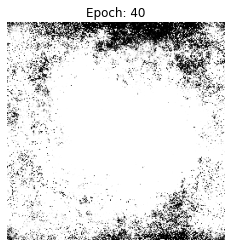

Epoch: 40, Step: 0, D-Loss: 0.155, D-Acc: 94.000, G-Loss: 2.688
Epoch: 40, Step: 50, D-Loss: 0.169, D-Acc: 95.000, G-Loss: 2.898
Epoch: 40, Step: 100, D-Loss: 0.167, D-Acc: 96.000, G-Loss: 2.820
Epoch: 40, Step: 150, D-Loss: 0.119, D-Acc: 97.000, G-Loss: 2.919
Epoch: 40, Step: 200, D-Loss: 0.109, D-Acc: 96.000, G-Loss: 2.663
Epoch: 40, Step: 250, D-Loss: 0.180, D-Acc: 93.000, G-Loss: 2.643
Epoch: 40, Step: 300, D-Loss: 0.130, D-Acc: 98.000, G-Loss: 2.740
Epoch: 40, Step: 350, D-Loss: 0.044, D-Acc: 100.000, G-Loss: 2.975
Epoch: 40, Step: 400, D-Loss: 0.131, D-Acc: 96.000, G-Loss: 2.861
Epoch: 40, Step: 450, D-Loss: 0.218, D-Acc: 93.000, G-Loss: 2.718
Epoch: 41, Step: 0, D-Loss: 0.211, D-Acc: 94.000, G-Loss: 2.866
Epoch: 41, Step: 50, D-Loss: 0.105, D-Acc: 97.000, G-Loss: 2.807
Epoch: 41, Step: 100, D-Loss: 0.096, D-Acc: 99.000, G-Loss: 3.010
Epoch: 41, Step: 150, D-Loss: 0.108, D-Acc: 96.000, G-Loss: 2.601
Epoch: 41, Step: 200, D-Loss: 0.110, D-Acc: 97.000, G-Loss: 2.688
Epoch: 41, Step

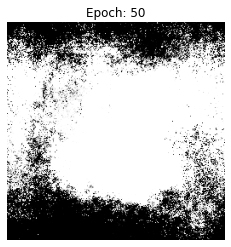

Epoch: 50, Step: 0, D-Loss: 0.059, D-Acc: 99.000, G-Loss: 2.905
Epoch: 50, Step: 50, D-Loss: 0.070, D-Acc: 99.000, G-Loss: 3.076
Epoch: 50, Step: 100, D-Loss: 0.043, D-Acc: 99.000, G-Loss: 3.043
Epoch: 50, Step: 150, D-Loss: 0.110, D-Acc: 96.000, G-Loss: 2.872
Epoch: 50, Step: 200, D-Loss: 0.244, D-Acc: 93.000, G-Loss: 3.108
Epoch: 50, Step: 250, D-Loss: 0.131, D-Acc: 94.000, G-Loss: 3.261
Epoch: 50, Step: 300, D-Loss: 0.066, D-Acc: 98.000, G-Loss: 2.971
Epoch: 50, Step: 350, D-Loss: 0.024, D-Acc: 100.000, G-Loss: 3.471
Epoch: 50, Step: 400, D-Loss: 0.115, D-Acc: 96.000, G-Loss: 3.109
Epoch: 50, Step: 450, D-Loss: 0.088, D-Acc: 98.000, G-Loss: 3.347
Epoch: 51, Step: 0, D-Loss: 0.068, D-Acc: 99.000, G-Loss: 3.153
Epoch: 51, Step: 50, D-Loss: 0.111, D-Acc: 96.000, G-Loss: 3.271
Epoch: 51, Step: 100, D-Loss: 0.160, D-Acc: 94.000, G-Loss: 3.010
Epoch: 51, Step: 150, D-Loss: 0.077, D-Acc: 98.000, G-Loss: 3.107
Epoch: 51, Step: 200, D-Loss: 0.046, D-Acc: 99.000, G-Loss: 2.844
Epoch: 51, Step

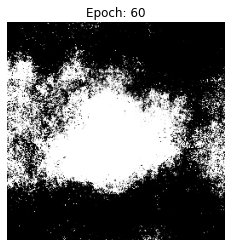

Epoch: 60, Step: 0, D-Loss: 0.191, D-Acc: 96.000, G-Loss: 3.287
Epoch: 60, Step: 50, D-Loss: 0.060, D-Acc: 98.000, G-Loss: 3.411
Epoch: 60, Step: 100, D-Loss: 0.104, D-Acc: 96.000, G-Loss: 3.747
Epoch: 60, Step: 150, D-Loss: 0.135, D-Acc: 97.000, G-Loss: 3.610
Epoch: 60, Step: 200, D-Loss: 0.090, D-Acc: 97.000, G-Loss: 3.074
Epoch: 60, Step: 250, D-Loss: 0.039, D-Acc: 99.000, G-Loss: 3.448
Epoch: 60, Step: 300, D-Loss: 0.038, D-Acc: 99.000, G-Loss: 3.516
Epoch: 60, Step: 350, D-Loss: 0.146, D-Acc: 94.000, G-Loss: 2.944
Epoch: 60, Step: 400, D-Loss: 0.056, D-Acc: 99.000, G-Loss: 3.635
Epoch: 60, Step: 450, D-Loss: 0.039, D-Acc: 100.000, G-Loss: 3.012
Epoch: 61, Step: 0, D-Loss: 0.070, D-Acc: 98.000, G-Loss: 3.588
Epoch: 61, Step: 50, D-Loss: 0.114, D-Acc: 96.000, G-Loss: 3.280
Epoch: 61, Step: 100, D-Loss: 0.121, D-Acc: 97.000, G-Loss: 3.284
Epoch: 61, Step: 150, D-Loss: 0.096, D-Acc: 98.000, G-Loss: 3.722
Epoch: 61, Step: 200, D-Loss: 0.017, D-Acc: 100.000, G-Loss: 3.779
Epoch: 61, Ste

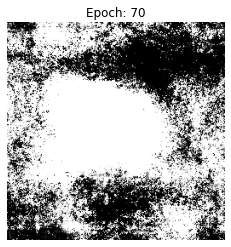

Epoch: 70, Step: 0, D-Loss: 0.090, D-Acc: 98.000, G-Loss: 3.715
Epoch: 70, Step: 50, D-Loss: 0.546, D-Acc: 96.000, G-Loss: 2.871
Epoch: 70, Step: 100, D-Loss: 0.052, D-Acc: 98.000, G-Loss: 3.173
Epoch: 70, Step: 150, D-Loss: 0.072, D-Acc: 99.000, G-Loss: 3.482
Epoch: 70, Step: 200, D-Loss: 0.057, D-Acc: 99.000, G-Loss: 3.765
Epoch: 70, Step: 250, D-Loss: 0.184, D-Acc: 94.000, G-Loss: 3.695
Epoch: 70, Step: 300, D-Loss: 0.092, D-Acc: 98.000, G-Loss: 3.132
Epoch: 70, Step: 350, D-Loss: 0.134, D-Acc: 98.000, G-Loss: 3.638
Epoch: 70, Step: 400, D-Loss: 0.121, D-Acc: 98.000, G-Loss: 3.599
Epoch: 70, Step: 450, D-Loss: 0.055, D-Acc: 99.000, G-Loss: 3.460
Epoch: 71, Step: 0, D-Loss: 0.063, D-Acc: 98.000, G-Loss: 3.528
Epoch: 71, Step: 50, D-Loss: 0.077, D-Acc: 98.000, G-Loss: 3.819
Epoch: 71, Step: 100, D-Loss: 0.128, D-Acc: 96.000, G-Loss: 3.620
Epoch: 71, Step: 150, D-Loss: 0.074, D-Acc: 98.000, G-Loss: 3.859
Epoch: 71, Step: 200, D-Loss: 0.065, D-Acc: 98.000, G-Loss: 3.911
Epoch: 71, Step:

KeyboardInterrupt: 

In [29]:
epochs = 200
batch_size = 100
steps = 500
noise_size = 50

losses_d = []
losses_g = []

sample_noise = get_random_noise(10, noise_size)
progression = {str(i) : [] for i in range(0,10)}

for i in range(0, epochs):
    if (i % 10 == 0):
        fake_samples = get_fake_samples(generator_network, 1, noise_size).reshape((256,256))
        plt.title(f'Epoch: {i}')
        plt.axis('off')
        plt.imshow(fake_samples, cmap='gray')
        plt.show()
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size).reshape((50,256,256))
        real_samples = get_real_samples(batch_size=batch_size//2)

        sample_imgs = generator_network.predict_on_batch(sample_noise)

        for n, k in enumerate(sample_imgs):
            if progression[str(n)] is not None:
                progression[str(n)] = progression[str(n)].append(k)
            else:
                progression[str(n)] = [k]

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # updating discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        gan_output = np.ones((batch_size))
        
        # updating generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)
        
        if j % 50 == 0:
            print(f'Epoch: {i}, Step: {j}, D-Loss: {loss_d[0]:.3f}, D-Acc: {loss_d[1] * 100:.3f}, G-Loss: {loss_g:.3f}')

In [ ]:
for i in range(5):
    show_generator_results(generator_network)

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:5000])
plt.plot(losses_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

In [51]:
generator_network.save(os.getcwd() + '\\generator_with_animation')
discriminator_network.save(os.getcwd() + '\\discriminator_with_animation')
gan_model.save(os.getcwd() + '\\gan_model_with_animation')

INFO:tensorflow:Assets written to: c:\Users\nikhi\OneDrive\Documents\gan testing\generator_with_animation\assets
INFO:tensorflow:Assets written to: c:\Users\nikhi\OneDrive\Documents\gan testing\discriminator_with_animation\assets
INFO:tensorflow:Assets written to: c:\Users\nikhi\OneDrive\Documents\gan testing\gan_model_with_animation\assets


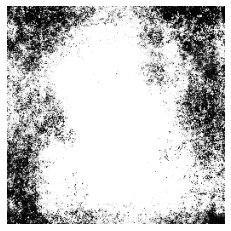

In [50]:
fake_samples = get_fake_samples(generator_network, 1, noise_size).reshape((256,256))
plt.axis('off')
plt.imshow(fake_samples, cmap='gray')

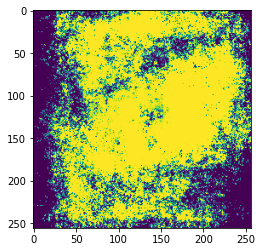

In [62]:
plt.imshow(np.array(progression['4']).reshape((256, 256)))